# Treadmill Versus Outdoor Running: Prediction Using A Random Forest Classifier on Biomechanical Measures of 181,909 Steps

### Natalie (Kramer) Kupperman, Jay Hertel
#### Exercise & Sport Injury Lab, University of Virginia

#### The follow code is an accompiament to RapidFire Presentation given at the National Athletic Training Association Clinical Symposia in Las Vegas, NV on June 24, 2019. The full abstract and data cleaning code is available on the GitHub repository. 

In [1]:
# import dependencies
import pandas as pd

In [2]:
# read in csv treadmill and outdoor runs
df = pd.read_csv("output/full_dataset.csv") #each row is a observation of (1) step

## Data Proprocessing Code

In [3]:
# The variables entered into the final model were choosen based on dimensionality reduction
# analysis and metrics that are important to athletic trainers.

total_df = df.filter(items = ['braking_gs', 'contact_ratio', 'contact_time', 
                              'cycle_time', 'flight_ratio', 'flight_time', 
                              'footstrike_type_new', 'impact_gs', 
                              'max_pronation_velocity','medium',
                              'pronation_excursion_fs_mp', 'pronation_excursion_mp_to',  
                              'step_length', 'step_rate', 'stride_pace'])
    
total_df.shape

(183641, 15)

In [4]:
# function to check for missing data
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(total_df.apply(num_missing, axis=0))

#Applying per row:
print("\nMissing values per row:")
print(total_df.apply(num_missing, axis=1).head()) 

Missing values per column:
braking_gs                   0
contact_ratio                0
contact_time                 0
cycle_time                   0
flight_ratio                 0
flight_time                  0
footstrike_type_new          0
impact_gs                    0
max_pronation_velocity       0
medium                       0
pronation_excursion_fs_mp    2
pronation_excursion_mp_to    1
step_length                  0
step_rate                    0
stride_pace                  0
dtype: int64

Missing values per row:
0    0
1    0
2    0
3    0
4    0
dtype: int64


In [5]:
# The above code was left in for example. Any large subset of missing 
# data was handled by reprocessing the data cleaning files. 

# remove observations with missing data (if any)
total_df = total_df.dropna()

## Classifier Code

In order to demonstrate the predictive value of ensemble methods in statistical learning, we walk through a logistics regression, tree classifier and random forest using an ROC 
and AUC to compare the models. 

In [10]:
# set outcome target for classifiers
target = total_df["medium"] #outcome variable (treadmill vs outdoor)

# replace strings with numbers
target = target.replace('outdoor', 0)
target = target.replace('treadmill', 1)
target_names = ["outdoor", "treadmill"]

# set data for classifers
data = total_df.drop("medium", axis=1) #variables that will be entered into model
feature_names = data.columns

In [11]:
# import dependency
from sklearn.model_selection import train_test_split

# split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

# train/test split allows us to analyze the model on unseen data (data that was not used
# to build the model)

Logistic Regression Model Score: 0.7268568939228927
AUC: 0.828


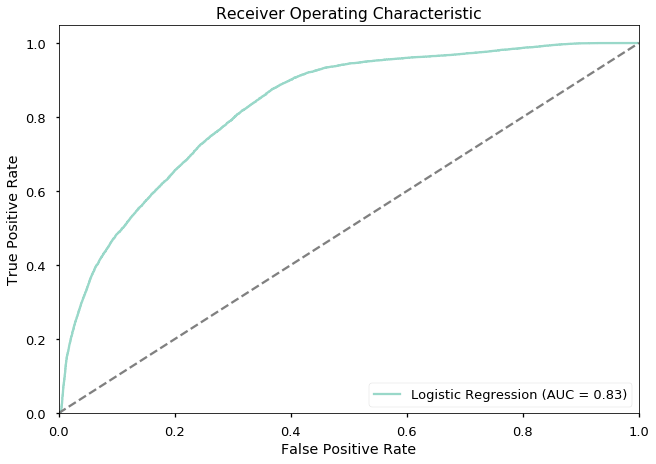

In [18]:
#import dependencies
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# logistics regression
logistic_regr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear') #model parameters
logistic_regr = logistic_regr.fit(X_train, y_train) #fit the model
y_pred_log = logistic_regr.predict(X_test) #predict outcome for test data

print(f"Logistic Regression Model Score: {logistic_regr.score(X_test, y_test)}")

# predict probabilities
probs_log = logistic_regr.predict_proba(X_test) #probability of outcome

# keep probabilities for the positive outcome only
probs_log = probs_log[:, 1]

# calculate AUC
auc_log = roc_auc_score(y_test, probs_log)
print(f'AUC: {auc_log:.3f}')

# calculate roc curve
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, probs_log)

# plot the ROC/AUC
plt.figure()
plt.style.use('seaborn-talk')
plt.plot(fpr_log, tpr_log, label = 'Logistic Regression (AUC = %0.2f)' % auc_log, color = '#99d8c9')
plt.plot([0, 1], [0, 1], '--', color = 'gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")

plt.savefig('output/Log_ROC', dpi = 400)
plt.show()

Tree Classifer Model Score: 0.9587671531256807
Tree Classifer AUC: 0.948


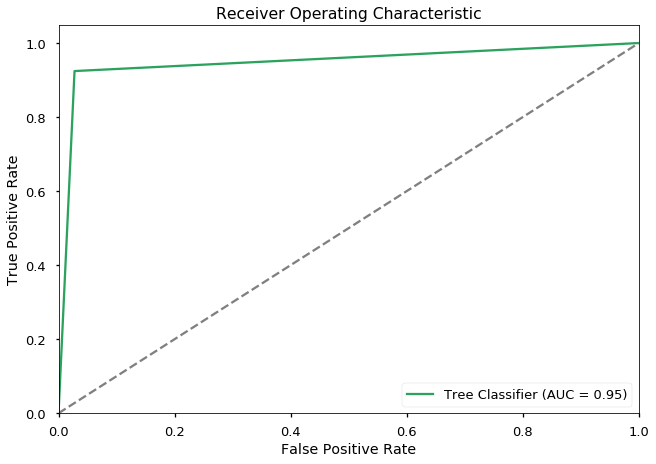

In [13]:
# import dependency
from sklearn import tree

# Decision Tree Classifer
clf = tree.DecisionTreeClassifier() #model parameters
clf = clf.fit(X_train, y_train) #fit model
y_pred_clf = clf.predict(X_test) #predict unseen data

print(f'Tree Classifer Model Score: {clf.score(X_test, y_test)}')

# predict probabilities
probs_clf = clf.predict_proba(X_test) #calculate probability of outcome

# keep probabilities for the positive outcome only
probs_clf = probs_clf[:, 1]

# calculate AUC
auc_clf = roc_auc_score(y_test, probs_clf)
print(f'Tree Classifer AUC: {auc_clf:.3f}')

# calculate roc curve
fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, probs_clf)

plt.figure()
plt.style.use('seaborn-talk')
plt.plot(fpr_clf, tpr_clf, label = 'Tree Classifier (AUC = %0.2f)' % auc_clf, color = '#2ca25f')
plt.plot([0, 1], [0, 1], '--', color = 'gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")

plt.savefig('output/Clf_ROC')
plt.show()

Random Forest Model Score: 0.9767806578087562
Random Forest AUC:0.997


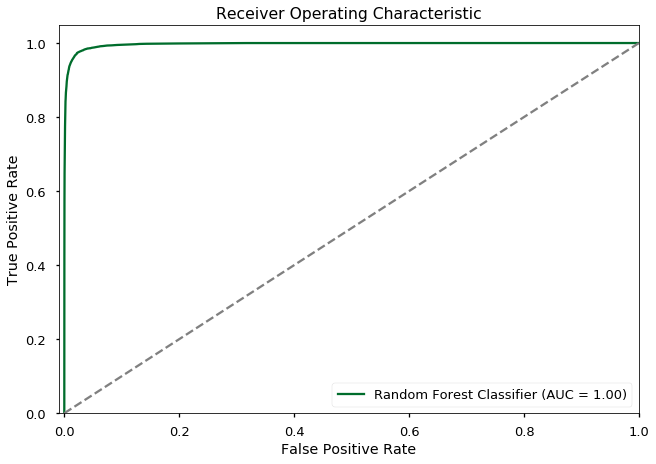

In [19]:
# import dependency
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf = RandomForestClassifier(n_estimators=200, oob_score = True) #model parameters
rf = rf.fit(X_train, y_train) #fit model
y_pred_rf = rf.predict(X_test) #predict on unseen data

print(f'Random Forest Model Score: {rf.score(X_test, y_test)}')

# predict probabilities
probs_rf = rf.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs_rf = probs_rf[:, 1]

# calculate AUC
auc_rf = roc_auc_score(y_test, probs_rf)
print(f'Random Forest AUC:{auc_rf:.3}')

# calculate roc curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)

plt.figure()
plt.style.use('seaborn-talk')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier (AUC = %0.2f)' % auc_rf, color = '#006d2c')
plt.plot([0, 1], [0, 1], '--', color = 'gray')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")

plt.savefig('output/RF_ROC')
plt.show()

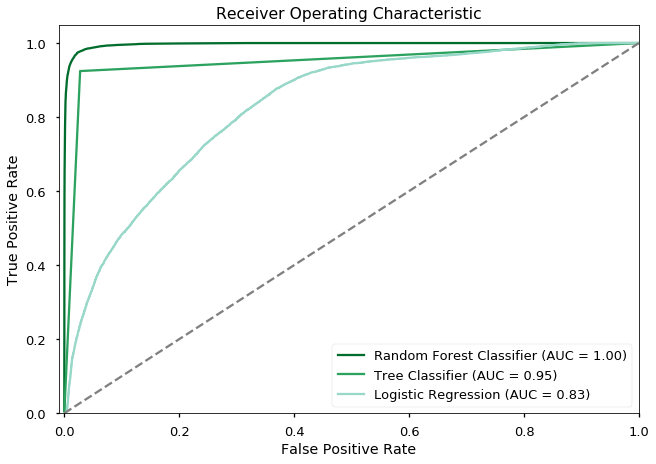

In [21]:
plt.figure()
plt.style.use('seaborn-talk')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier (AUC = %0.2f)' % auc_rf, color = '#006d2c')
plt.plot(fpr_clf, tpr_clf, label = 'Tree Classifier (AUC = %0.2f)' % auc_clf, color = '#2ca25f')
plt.plot(fpr_log, tpr_log, label = 'Logistic Regression (AUC = %0.2f)' % auc_log, color = '#99d8c9')
plt.plot([0, 1], [0, 1], '--', color = 'gray')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('output/All_ROC')
plt.show()

In [ ]:
print(f'LR Classification Report: \n {metrics.classification_report(y_test, y_pred_log)}')
print(f'Clf Classification Report: \n {metrics.classification_report(y_test, y_pred_clf)}')
print(f'RF Classification Report: \n {metrics.classification_report(y_test, y_pred_rf)}')